# Training on U-Net Model

<img src="https://github.com/zhixuhao/unet/blob/master/img/u-net-architecture.png?raw=true">

baseline detection


## To Do
- [ ] Implement Dice Score


## Problems
- [ ] Unbalence shape (492,968)
- [ ] Error loss function 
        - The model tend to fit the background

## Create U-net framework
- with pretrain parameters

In [1]:
"""U-net model"""
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (256,256,1)):
    w, h, z = input_size[0],input_size[1],input_size[2]
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

Using TensorFlow backend.


## Data preparation

Separate the images and labels to train and test dataset

Need to specify the image folder and training folder

## References
1. [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [2]:
"""Retrieve dataset"""
import nbimporter
from dataPrepare import ImgReader, get_img_mask, colorfilter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from skimage.transform import resize

# Setting
IMGFOLDER ="test_train/img"
MASKFOLDER = "test_train/label"

# Retrieve data
imgs, masks = get_img_mask(imgfolder=IMGFOLDER,
                           maskfolder=MASKFOLDER,
                           filtermask=True,
                             grayimg=True)

# Resize
imgs =  [np.expand_dims(resize(img, (128,128)), axis=2) for img in imgs]
masks = [np.expand_dims(resize(mask, (128,128)), axis=2) for mask in masks]

# Splitting Training and testing data
x_train, x_test, y_train, y_test = train_test_split(
    imgs, masks, test_size=0.33, random_state=42)

Importing Jupyter notebook from dataPrepare.ipynb


/Users/stevenchiu/miniconda3/envs/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/stevenchiu/miniconda3/envs/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [3]:
"""Summary of Training and Test dataset"""
print("Number of training images: \t{}; Shape:{}".format(len(x_train), x_train[0].shape))
print("Number of testing images: \t{}; Shape:{}".format(len(x_test), x_test[0].shape))

Number of training images: 	4; Shape:(128, 128, 1)
Number of testing images: 	2; Shape:(128, 128, 1)


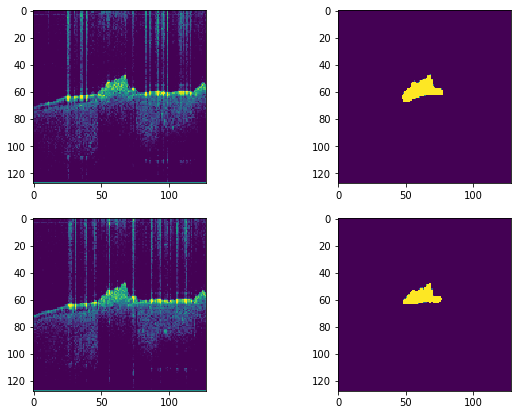

In [5]:
"""Plot"""
cr, cs = random.randint(0, len(x_train)-1), random.randint(0, len(x_test)-1)


fig, ax = plt.subplots(2,2,figsize=(10,7))
ax[0,0].imshow(x_train[cr][:,:,0])
ax[0,1].imshow(y_train[cr][:,:,0])
ax[1,0].imshow(x_test[cs][:,:,0])
ax[1,1].imshow(y_test[cs][:,:,0])

# Training



## References
1. [VGG16+U-Net on Carvana](https://www.kaggle.com/kmader/vgg16-u-net-on-carvana#Building-the-Model)
    - Using a pretrained model to segment
2. [U-Net base on ResNet34 Transfer learning (Keras)](https://www.kaggle.com/super13579/u-net-base-on-resnet34-transfer-learning-keras)
3. [Implementation of deep learning framework -- Unet, using Keras](https://github.com/zhixuhao/unet)
4. [Easier Keras ImageDataGenerator](https://www.kaggle.com/raghakot/easier-keras-imagedatagenerator)
    - About data generator

In [6]:
model = unet(input_size = (128,128,1))

model.fit(np.asarray(x_train), np.asarray(y_train), epochs=3, batch_size=2)

/Users/stevenchiu/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 1/3
4/4 [==============================] - 12s 3s/step - loss: 0.8226 - acc: 0.5343
Epoch 2/3
4/4 [==============================] - 7s 2s/step - loss: 0.4362 - acc: 0.9748
Epoch 3/3
4/4 [==============================] - 9s 2s/step - loss: 0.2425 - acc: 0.9805


In [7]:
score = model.predict(np.asarray(x_train))

In [8]:
score[0].shape

(128, 128, 1)

In [11]:
y_train[i].shape

(128, 128, 1)

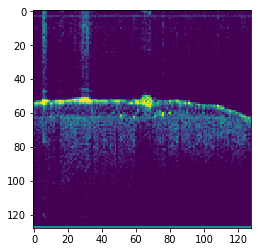

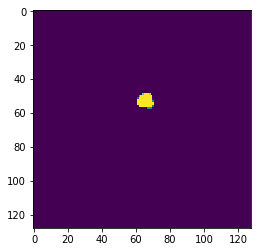

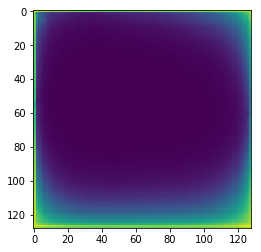

In [10]:
i = 0
for im in [x_train[i][:,:,0],y_train[i][:,:,0],score[i][:,:,0]]:
    plt.figure()
    plt.imshow(im)

## Backup code

def get_unet(patch_height,patch_width,n_ch):
    inputs = Input(shape=(n_ch,patch_height,patch_width))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(inputs)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv3)

    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2,up1],axis=1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up1)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv4)
    #
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1,up2], axis=1)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(up2)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv5)
    #
    conv6 = Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_first')(conv5)
    conv6 = core.Reshape((2,patch_height*patch_width))(conv6)
    conv6 = core.Permute((2,1))(conv6)
    ############
    conv7 = core.Activation('softmax')(conv6)

    model = Model(inputs=inputs, outputs=conv7)

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
    #if optimizer= 'sgd', the default values for the hyperparameters will be used.
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])

    return model
